# Проект (Телеком)

- Проект (Телеком)
- Описание Проекта
- Выгрузка Данных
- Исследовательский Анализ + Предобработка Данных
- Обучение Моделей
- Тестировка Модели
- Вывод

# Описание Проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.

# Выгрузка Данных

In [1]:
import sys
import random

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
RANDOM_STATE = 180623

In [3]:
random.seed(RANDOM_STATE)

### Описание Данных
database - telecom.
- contract - информация о договорах;
- personal - персональные данные клиентов;
- internet - информация об интернет-услугах;
- phone - информация об услугах телефонии.

(Информация о договорах актуальна на 1 февраля 2020.)

In [4]:
db_config = {
'user': 'praktikum_student',# имя пользователя,
'password': 'Sdf4$2;d-d30pp',# пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432,# порт подключения,
'database': 'data-science-final'# название базы данных,
}

In [5]:
def connect(params_dic):
    conn = None
    try:
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

In [6]:
def postgresql_to_dataframe(conn, select_query, column_names):
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

In [7]:
conn = connect(db_config)

Connecting to the PostgreSQL database...
Connection successful


### Проверим Данные

In [8]:
query_contract_info = \
"SELECT table_name, column_name, data_type FROM information_schema.columns WHERE table_name = 'contract';"
columns_contract_info = ['table_name', 'column_name', 'data_type']
contract_info = postgresql_to_dataframe(conn, query_contract_info, columns_contract_info)

In [9]:
contract_info

,table_name,column_name,data_type
0,contract,customerID,text
1,contract,BeginDate,date
2,contract,EndDate,date
3,contract,Type,text
4,contract,PaperlessBilling,text
5,contract,PaymentMethod,text
6,contract,MonthlyCharges,numeric
7,contract,TotalCharges,numeric


In [10]:
query_personal_info = \
"SELECT table_name, column_name, data_type FROM information_schema.columns WHERE table_name = 'personal';"
columns_personal_info = ['table_name', 'column_name', 'data_type']
personal_info = postgresql_to_dataframe(conn, query_personal_info, columns_personal_info)

In [11]:
personal_info

,table_name,column_name,data_type
0,personal,customerID,text
1,personal,gender,text
2,personal,SeniorCitizen,integer
3,personal,Partner,text
4,personal,Dependents,text


In [12]:
query_internet_info =\
"SELECT table_name, column_name, data_type FROM information_schema.columns WHERE table_name = 'internet';"
columns_internet_info = ['table_name', 'column_name', 'data_type']
internet_info = postgresql_to_dataframe(conn, query_internet_info, columns_internet_info)

In [13]:
internet_info

,table_name,column_name,data_type
0,internet,c1,text
1,internet,c2,text
2,internet,c3,text
3,internet,c4,text
4,internet,c5,text
5,internet,c6,text
6,internet,c7,text
7,internet,c8,text


В описании проекта данные о таблице 'internet' выглядят вот так:
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Стоит выбрать несколько строк данных чтобы проверить если данные хранятся в таком же порядке.

In [14]:
query_internet_sample =\
"SELECT * FROM telecom.internet LIMIT 5;"
columns_internet_sample = ['customerID', 'ItnernetService', 'OnlineSecurity', 'OnlineBackup',
                           'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
internet_sample = postgresql_to_dataframe(conn, query_internet_sample, columns_internet_sample)

In [15]:
internet_sample

,customerID,ItnernetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No


In [16]:
query_phone_info =\
"SELECT table_name, column_name, data_type FROM information_schema.columns WHERE table_name = 'phone';"
columns_phone_info = ['table_name', 'column_name', 'data_type']
phone_info = postgresql_to_dataframe(conn, query_phone_info, columns_phone_info)

In [17]:
phone_info

,table_name,column_name,data_type
0,phone,c1,text
1,phone,c2,text


В описании проекта данные о таблице 'phone' выглядят вот так:
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям

Стоит выбрать несколько строк данных чтобы проверить если данные хранятся в таком же порядке.

In [18]:
query_phone_sample = \
"SELECT * FROM telecom.phone LIMIT 5;"
columns_phone_sample = ['customerID', 'MultipleLines']
phone_sample = postgresql_to_dataframe(conn, query_phone_sample, columns_phone_sample)

In [19]:
phone_sample

,customerID,MultipleLines
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes


# Исследовательскй Анализ + Предобрабока Данных

- Наша модель будет предсказывать если данные ползьватель относится к гуппе которые скорее всего перестанут пользоваться услугами компании.
- Нам нужно будет выделить тех ползователей которые перeстали пользоваться услугами и скорее всего мы будем использовать 'telecom.contract' таблицу и 'EndDate' колонку.
- У нас будут абоненты с уникальным идентификатором 'customerID' и целевой переменной.
- Только остается объединить все остальные полезные признаки (Feature Engineering).

Feature Engineering:
- Большинство признаков по 'customerID' можно будет проверить на корреляцию с не большой выборкой для скорости.
- Когда мы будем проверять корреляцию нужно будет обращать внимание на качественные и количественные переменные.
- Можно будет еще построить признаки по дате:
  - Сколько обонент уже ползуется услугами.
  - Можно еще провести анализ по окончании действия договоров в зависимости от времени года.
  - Этот пункт как совет для компании как улучшить сервис.

Проверка корреляции:
- Мы построим таблицу состоящую из 'customerID' и 'terminated' (целевой признак)
- Потом будем рандомно выбирать данные из колонок и сопостовлять по 'customerID'

In [20]:
query_customer =\
'SELECT "customerID", "EndDate" FROM telecom.contract;'
columns_customer = ['customerID', 'EndDate']
customer = postgresql_to_dataframe(conn, query_customer, columns_customer)

"posgreSQL работает с учетом регистра, нужно использовать кавычки правильно"

In [21]:
customer.sample(4)

,customerID,EndDate
3866,7629-WIXZF,None
3406,7228-PAQPD,None
293,9878-TNQGW,2019-12-01
3081,5035-BVCXS,None


In [22]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7043 non-null   object
 1   EndDate     1869 non-null   object
dtypes: object(2)
memory usage: 110.2+ KB


In [23]:
customer['terminated'] = customer.EndDate.notna()

### Проверка Качественных Параметров
- Type
- PaperlessBilling
- PaymentMethod
- gender
- SeniorCitizen
- Partner
- Dependents
- ItnernetService - OHE?
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport
- StreamingTV
- StreamingMovies
- MultipleLines

In [24]:
query_categorical =\
'''
WITH good_ids AS (
    SELECT "customerID"
    FROM telecom.contract
    ORDER BY RANDOM()
    LIMIT 1000
), contract_categorical AS (
    SELECT "customerID", "Type", "PaperlessBilling", "PaymentMethod"
    FROM telecom.contract
    WHERE "customerID" IN (
        SELECT *
        FROM good_ids
    )
), personal_categorical AS (
    SELECT *
    FROM telecom.personal
    WHERE "customerID" IN (
        SELECT *
        FROM good_ids
    )
), internet_categorical AS (
    SELECT *
    FROM telecom.internet
    WHERE "c1" IN (
        SELECT *
        FROM good_ids
    )
), phone_categorical AS (
    SELECT *
    FROM telecom.phone
    WHERE "c1" IN (
        SELECT *
        FROM good_ids
    )
)

SELECT 
    key.*, 
    cc."Type", cc."PaperlessBilling", cc."PaymentMethod",
    pc."gender", pc."SeniorCitizen", pc."Partner", "Dependents",
    ic."c2", ic."c3", ic."c4", ic."c5", ic."c6", ic."c7", ic."c8",
    phone_categorical."c2"
FROM good_ids AS key
    INNER JOIN contract_categorical AS cc
    ON key."customerID" = cc."customerID"
    INNER JOIN personal_categorical AS pc
    ON key."customerID" = pc."customerID"
    INNER JOIN internet_categorical AS ic
    ON key."customerID" = ic."c1"
    INNER JOIN phone_categorical
    ON key."customerID" = phone_categorical."c1"
    ;
'''
columns_categorical = [
    'customerID', 
    'Type', 'PaperlessBilling', 'PaymentMethod',
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
    'MultipleLines'
]
categorical = postgresql_to_dataframe(conn, query_categorical, columns_categorical)

In [25]:
categorical.head()

,customerID,Type,PaperlessBilling,PaymentMethod,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,0003-MKNFE,Month-to-month,No,Mailed check,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes
1,0013-SMEOE,Two year,Yes,Bank transfer (automatic),Female,1,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,No
2,0020-INWCK,Two year,Yes,Credit card (automatic),Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,Yes,Yes
3,0107-YHINA,Month-to-month,Yes,Electronic check,Male,0,No,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
4,0135-NMXAP,Month-to-month,Yes,Bank transfer (automatic),Female,0,No,No,Fiber optic,No,Yes,No,No,Yes,No,Yes


In [26]:
for column in categorical.columns:
    print("{:20} {}".format(column, len(pd.unique(categorical[column]))))

customerID           697
Type                 3
PaperlessBilling     2
PaymentMethod        4
gender               2
SeniorCitizen        2
Partner              2
Dependents           2
InternetService      2
OnlineSecurity       2
OnlineBackup         2
DeviceProtection     2
TechSupport          2
StreamingTV          2
StreamingMovies      2
MultipleLines        2


Благодоря INNER JOIN у нас нет пропусков, но видно что теперь выборка содержит меньше значений, этого должно хватить для корреляции 

- 'Type' нужно провести OneHotEncoding
- 'PaymentMethod' нужно провести OneHotEncoding

In [27]:
pd.unique(categorical.Type)

array(['Month-to-month', 'Two year', 'One year'], dtype=object)

In [28]:
categorical['Type_month_to_month'] = categorical.Type == 'Month-to-month'
categorical['Type_one_year'] = categorical.Type == 'One year'
categorical['Type_two_year'] = categorical.Type == 'Two year'
categorical = categorical.drop(columns=['Type'])

In [29]:
pd.unique(categorical.PaymentMethod)

array(['Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check'], dtype=object)

In [30]:
categorical['PaymentMethod_electronic_check'] = categorical['PaymentMethod'] == 'Electronic check'
categorical['PaymentMethod_bank_transfer_(automatic)'] = categorical['PaymentMethod'] == 'Bank transfer (automatic)'
categorical['PaymentMethod_credict_card_(automatic)'] = categorical['PaymentMethod'] == 'Credit card (automatic)'
categorical['PaymentMethod_mailed_check'] = categorical['PaymentMethod'] == 'Mailed check'
categorical = categorical.drop(columns=['PaymentMethod'])

In [31]:
categorical['gender_male'] = categorical['gender'] == 'Male'
categorical = categorical.drop(columns=['gender'])

In [32]:
categorical['SeniorCitizen'] = categorical['SeniorCitizen'] == 1

In [33]:
categorical['InternetService_fiber_optic_not_DSL'] = categorical['InternetService'] == 'Fiber optic'
categorical = categorical.drop(columns=['InternetService'])

In [34]:
yes_no_cols = ['PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
for col in yes_no_cols:
    categorical[col] = categorical[col] == 'Yes'

In [35]:
categorical.head(3)

,customerID,PaperlessBilling,SeniorCitizen,Partner,Dependents,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,MultipleLines,Type_month_to_month,Type_one_year,Type_two_year,PaymentMethod_electronic_check,PaymentMethod_bank_transfer_(automatic),PaymentMethod_credict_card_(automatic),PaymentMethod_mailed_check,gender_male,InternetService_fiber_optic_not_DSL
0,0003-MKNFE,False,False,False,False,False,False,False,False,False,...,True,True,False,False,False,False,False,True,True,False
1,0013-SMEOE,True,True,True,False,True,True,True,True,True,...,False,False,False,True,False,True,False,False,False,True
2,0020-INWCK,True,False,True,True,False,True,True,False,False,...,True,False,False,True,False,False,True,False,False,True


In [36]:
categorical = pd.merge(categorical, customer, on='customerID', how='inner')

In [37]:
categorical = categorical.drop(columns=['EndDate'])

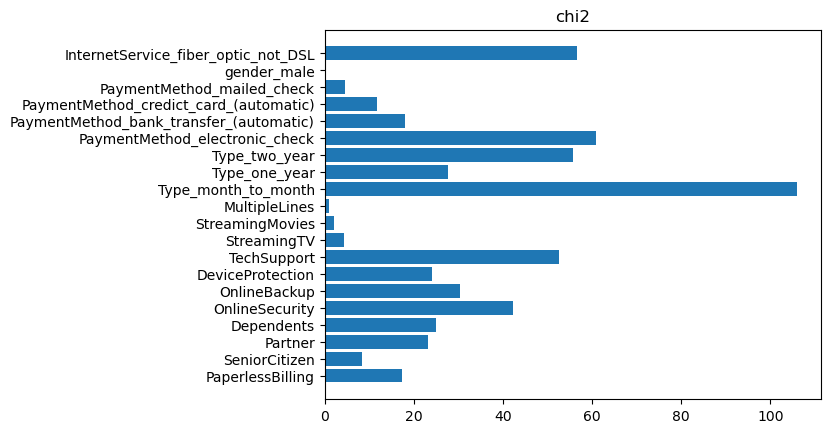

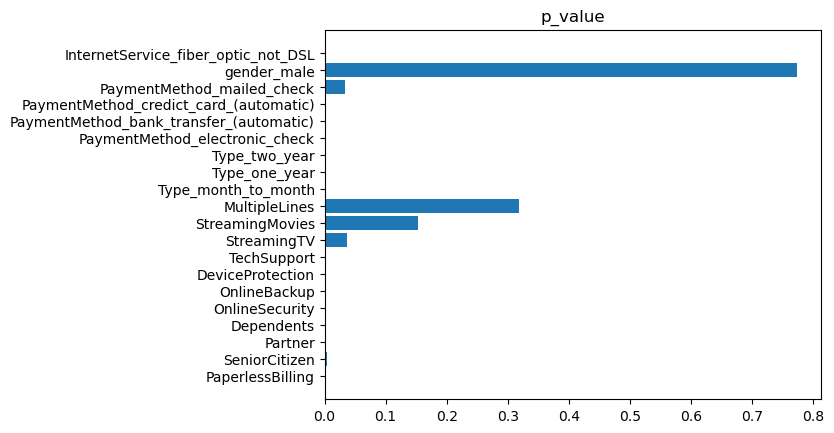

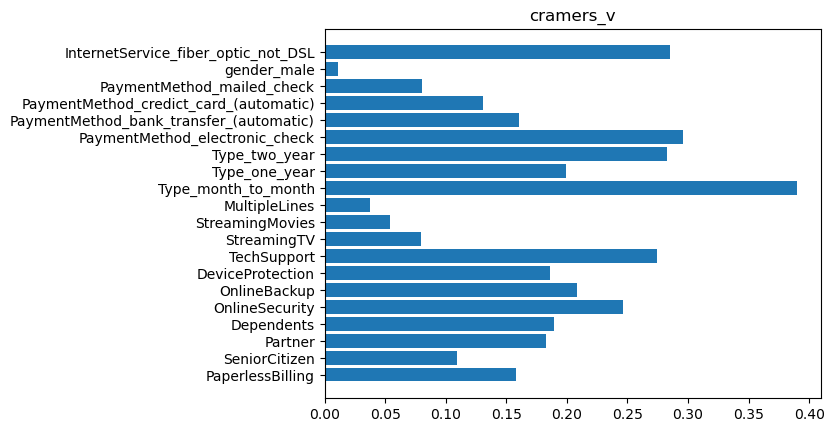

In [38]:
names = []
chi2_list = []
p_value_list = []
cramers_v_list = []

significant_cols = []

for col in categorical.columns:
    if col == 'customerID' or col == 'terminated':
        continue
    
    # Create a contingency table
    contingency_table = pd.crosstab(categorical[col], categorical['terminated'])

    # Perform the chi-square test
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)

    # Calculate Cramer's V
    n = contingency_table.sum().sum()
    phi_corr = np.sqrt(chi2 / (n * (min(contingency_table.shape)-1)))
    cramers_v = phi_corr
    
    if cramers_v > 0.04:
        significant_cols.append(col)
    
    names.append(col)
    chi2_list.append(chi2)
    p_value_list.append(p_value)
    cramers_v_list.append(cramers_v)
    
#     print('{:40} Chi-square-{:5.1f} P-value-{:.2f} Cramer\'s V-{:.2f}'\
#           .format(str(col), chi2, p_value, cramers_v))
x_axis = range(1, len(names) + 1)
plt.barh(names, chi2_list)
plt.title('chi2')
plt.show()
plt.barh(names, p_value_list)
plt.title('p_value')
plt.show()
plt.barh(names, cramers_v_list)
plt.title('cramers_v')
plt.show()

In [39]:
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = stats.chi2_contingency(contingency_table)

    n = contingency_table.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

    return cramers_v

In [40]:
# Calculate the correlation matrixa
categorical[['terminated', 'PaperlessBilling']].corr(method=cramers_v)

,terminated,PaperlessBilling
terminated,1.000000,0.157762
PaperlessBilling,0.157762,1.000000


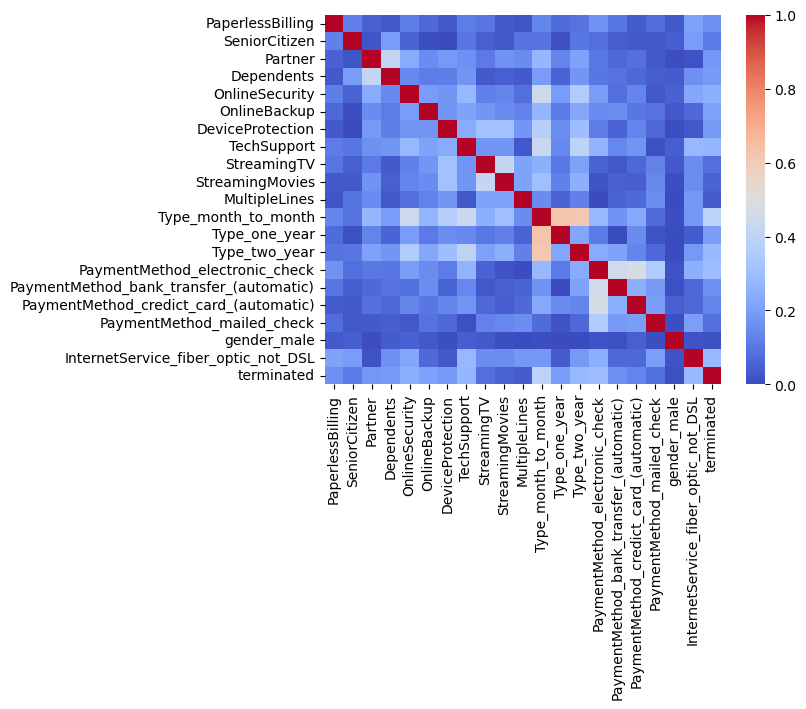

In [41]:
# Calculate the correlation matrixa
correlation_matrix = categorical.drop(columns=['customerID']).corr(method=cramers_v)

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, cmap='coolwarm')

# Show the plot
plt.show()

In [42]:
significant_cols

['PaperlessBilling',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Type_month_to_month',
 'Type_one_year',
 'Type_two_year',
 'PaymentMethod_electronic_check',
 'PaymentMethod_bank_transfer_(automatic)',
 'PaymentMethod_credict_card_(automatic)',
 'PaymentMethod_mailed_check',
 'InternetService_fiber_optic_not_DSL']

In [43]:
print('target value count ratio {:.2f}'.format(categorical.terminated.sum() /\
                                               categorical.shape[0]))

target value count ratio 0.35


Это количество данных где мы потеряли клиентов, чтобы корреляция не потерялась

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> Напоминаю о проверке дисбаланса классов
    
Знай, что метрика ROC-AUC устойчива к дисбалансу классов, поэтому нам можно не проводить балансировку классов

### Проверим Корреляцию на Колличественных Данных

- MontlyCharges
- TotalCharges

In [44]:
query_numerical =\
'''
WITH good_ids AS (
    SELECT "customerID"
    FROM telecom.contract
    ORDER BY RANDOM()
    LIMIT 1000
)

SELECT "customerID", "MonthlyCharges", "TotalCharges"
FROM telecom.contract
WHERE "customerID" IN (
    SELECT *
    FROM good_ids
);
'''
columns_numerical = ['customerID', 'MonthlyCharges', 'TotalCharges']
numerical = postgresql_to_dataframe(conn, query_numerical, columns_numerical)

In [45]:
numerical.head(3)

,customerID,MonthlyCharges,TotalCharges
0,4367-NUYAO,25.75,None
1,2923-ARZLG,19.7,None
2,2775-SEFEE,61.9,None


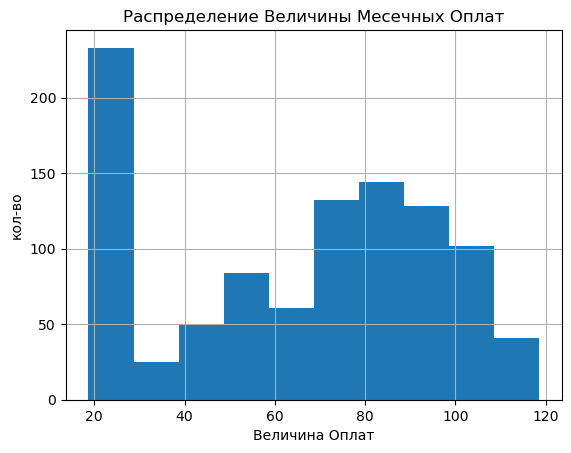

In [46]:
numerical.MonthlyCharges.hist()
plt.title('Распределение Величины Месечных Оплат')
plt.xlabel('Величина Оплат')
plt.ylabel('кол-во')
plt.show()

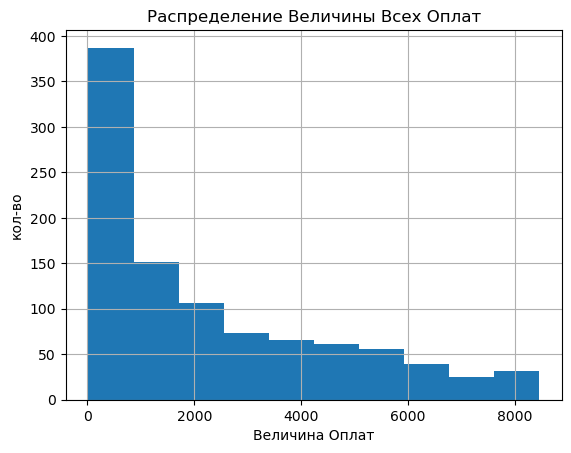

In [47]:
numerical.TotalCharges.hist()
plt.title('Распределение Величины Всех Оплат')
plt.xlabel('Величина Оплат')
plt.ylabel('кол-во')
plt.show()

In [48]:
numerical = pd.merge(numerical, customer, on='customerID', how='inner')

In [49]:
numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customerID      1000 non-null   object
 1   MonthlyCharges  1000 non-null   object
 2   TotalCharges    996 non-null    object
 3   EndDate         271 non-null    object
 4   terminated      1000 non-null   bool  
dtypes: bool(1), object(4)
memory usage: 32.4+ KB


In [50]:
numerical.MonthlyCharges = numerical.MonthlyCharges.astype('float')

In [51]:
numerical.TotalCharges = numerical.TotalCharges.astype('float')

In [52]:
numerical.MonthlyCharges.corr(numerical.terminated)

0.20682320136210716

In [53]:
numerical.TotalCharges.corr(numerical.terminated)

-0.17383681124650874

Наблюдается корреляция которая пригодится

Построим новые данные:
- сколько клиент на продолжении времени пользуется услугами

In [54]:
query_contract_length =\
'''
WITH good_ids AS (
    SELECT "customerID"
    FROM telecom.contract
    ORDER BY RANDOM()
    LIMIT 1000
)

SELECT "customerID", COALESCE("EndDate", '2020-02-1') - "BeginDate" AS "ContractLifeDays"
FROM telecom.contract
WHERE "customerID" IN (
    SELECT *
    FROM good_ids
);
'''
columns_contract_length = ['customerID', 'ContractLifeDays']
contract_length = postgresql_to_dataframe(conn, query_contract_length, columns_contract_length)

In [55]:
contract_length.head(5)

,customerID,ContractLifeDays
0,8779-QRDMV,297
1,5698-BQJOH,241
2,5919-TMRGD,206
3,6207-WIOLX,397
4,1875-QIVME,160


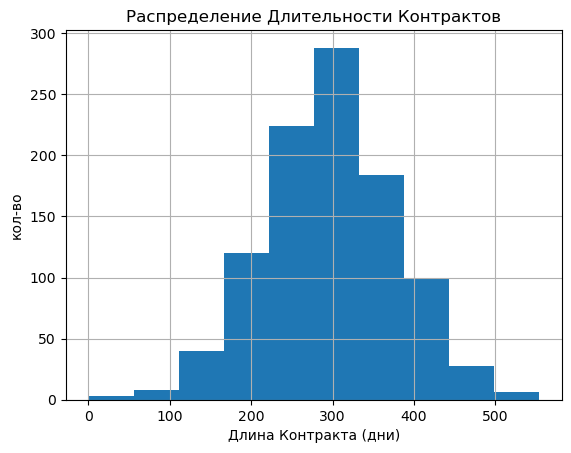

In [56]:
contract_length.ContractLifeDays.hist()
plt.title('Распределение Длительности Контрактов')
plt.xlabel('Длина Контракта (дни)')
plt.ylabel('кол-во')
plt.show()

In [57]:
contract_length = pd.merge(contract_length, customer, on='customerID', how='inner')

In [58]:
contract_length = contract_length.drop(columns='EndDate')

In [59]:
contract_length.head()

,customerID,ContractLifeDays,terminated
0,8779-QRDMV,297,True
1,5698-BQJOH,241,True
2,5919-TMRGD,206,True
3,6207-WIOLX,397,True
4,1875-QIVME,160,True


In [60]:
print('target value count ratio {:.2f}'.format(contract_length.terminated.sum() /\
                                               contract_length.shape[0]))

target value count ratio 0.25


In [61]:
contract_length.ContractLifeDays.corr(contract_length.terminated)

-0.00517189550145891

Видно что корреляция очень слабая, даже не стоит использовать эти данные.

### Выгрузка Данных

In [62]:
significant_cols

['PaperlessBilling',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Type_month_to_month',
 'Type_one_year',
 'Type_two_year',
 'PaymentMethod_electronic_check',
 'PaymentMethod_bank_transfer_(automatic)',
 'PaymentMethod_credict_card_(automatic)',
 'PaymentMethod_mailed_check',
 'InternetService_fiber_optic_not_DSL']

In [63]:
internet_sample.head(2)

,customerID,ItnernetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No


In [64]:
query_df = \
'''
SELECT 
    CASE
        WHEN c."EndDate" IS NOT NULL THEN TRUE
        ELSE FALSE
    END AS terminated,
    COALESCE(c."EndDate", '2020-02-1') - c."BeginDate" AS "ContractLifeDays",
    c."Type", c."PaymentMethod", c."MonthlyCharges", c."TotalCharges", c."PaperlessBilling",
    p."SeniorCitizen", p."Partner", p."Dependents",
    i."c2", i."c3", i."c4", i."c5", i."c6", i."c7", i."c8",
    phone."c2"
FROM telecom.contract AS c
    LEFT JOIN telecom.personal AS p
    ON c."customerID" = p."customerID"
    LEFT JOIN telecom.internet AS i
    ON c."customerID" = i."c1"
    LEFT JOIN telecom.phone
    ON c."customerID" = phone."c1"
'''
columns_df = ['terminated', 'days', 'type', 'payment_method', 'monthly_charges',
              'total_charges', 'paperless_billing', 'senior_citizen', 'partner', 'dependents',
              'internet_service', 'online_security', 'online_backup', 'device_protection', 
              'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']
df = postgresql_to_dataframe(conn, query_df, columns_df)

In [65]:
df.head(2)

,terminated,days,type,payment_method,monthly_charges,total_charges,paperless_billing,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,False,0,Two year,Bank transfer (automatic),52.55,None,Yes,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,None
1,False,0,Two year,Mailed check,20.25,None,No,0,No,Yes,None,None,None,None,None,None,None,No


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   terminated         7043 non-null   bool  
 1   days               7043 non-null   int64 
 2   type               7043 non-null   object
 3   payment_method     7043 non-null   object
 4   monthly_charges    7043 non-null   object
 5   total_charges      7032 non-null   object
 6   paperless_billing  7043 non-null   object
 7   senior_citizen     7043 non-null   int64 
 8   partner            7043 non-null   object
 9   dependents         7043 non-null   object
 10  internet_service   5517 non-null   object
 11  online_security    5517 non-null   object
 12  online_backup      5517 non-null   object
 13  device_protection  5517 non-null   object
 14  tech_support       5517 non-null   object
 15  streaming_tv       5517 non-null   object
 16  streaming_movies   5517 non-null   object


In [67]:
df.monthly_charges = df.monthly_charges.astype('float')
df.total_charges = df.total_charges.astype('float')

In [68]:
df.days = df.total_charges.fillna(0)
df.monthly_charges = df.monthly_charges.fillna(0)
df.total_charges = df.total_charges.fillna(0)

In [69]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(df[col].value_counts())

type
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64
payment_method
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64
paperless_billing
Yes    4171
No     2872
Name: count, dtype: int64
partner
No     3641
Yes    3402
Name: count, dtype: int64
dependents
No     4933
Yes    2110
Name: count, dtype: int64
internet_service
Fiber optic    3096
DSL            2421
Name: count, dtype: int64
online_security
No     3498
Yes    2019
Name: count, dtype: int64
online_backup
No     3088
Yes    2429
Name: count, dtype: int64
device_protection
No     3095
Yes    2422
Name: count, dtype: int64
tech_support
No     3473
Yes    2044
Name: count, dtype: int64
streaming_tv
No     2810
Yes    2707
Name: count, dtype: int64
streaming_movies
No     2785
Yes    2732
Name: count, dtype: int64
multiple_lines
No     3390
Yes    2971
Name: count, dtype: int

Не знаю как это можно прокоментировать

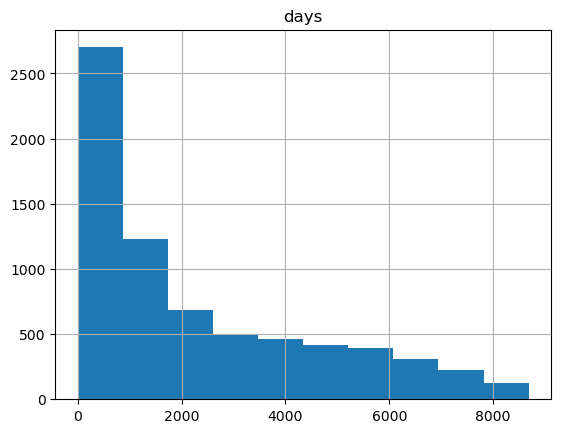

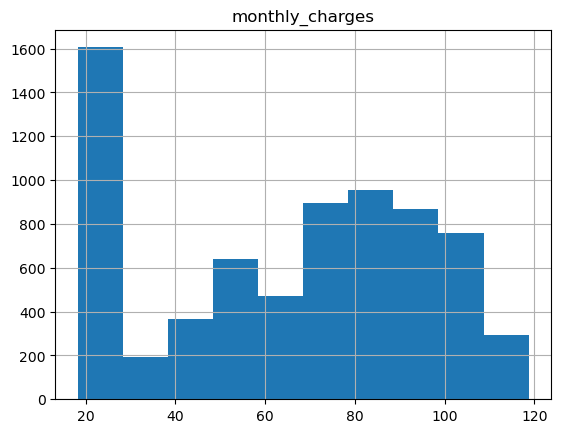

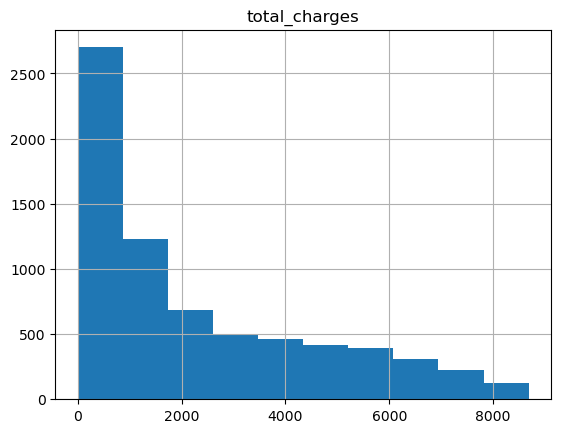

In [70]:
for col in df.columns:
    if df[col].dtype == 'float64' or df[col].dtype == 'float64':
        df[col].hist()
        plt.title(col)
        plt.show()

Данные распределенные нормально

In [71]:
df.senior_citizen = df.senior_citizen.fillna(0)

In [72]:
for col in df.columns:
    if df[col].dtype == 'object':
        print('{:20} {}'.format(col, pd.unique(df[col])))

type                 ['Two year' 'Month-to-month' 'One year']
payment_method       ['Bank transfer (automatic)' 'Mailed check' 'Electronic check'
 'Credit card (automatic)']
paperless_billing    ['Yes' 'No']
partner              ['Yes' 'No']
dependents           ['Yes' 'No']
internet_service     ['DSL' None 'Fiber optic']
online_security      ['Yes' None 'No']
online_backup        ['No' None 'Yes']
device_protection    ['Yes' None 'No']
tech_support         ['Yes' None 'No']
streaming_tv         ['Yes' None 'No']
streaming_movies     ['No' None 'Yes']
multiple_lines       [None 'No' 'Yes']


где можно заполним пропуски на 'No' в последнем случаем заполним 'DSL' так как это более частый провайдер

In [73]:
df.internet_service = df.internet_service.fillna('DSL')

In [74]:
df = df.fillna('No')

In [75]:
enc = OneHotEncoder(drop='first')

In [76]:
df_train, df_test = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE)

In [77]:
X_train_cat = enc.fit_transform(
    df_train.drop(columns=['terminated', 'days', 
                                 'monthly_charges', 'total_charges'])).toarray()

In [78]:
sca = StandardScaler()

In [79]:
X_train_num = sca.fit_transform(df_train[['days', 'monthly_charges', 'total_charges']])

In [80]:
X_train = np.hstack((X_train_cat, X_train_num))

In [81]:
X_test_cat = enc.transform(df_test.drop(columns=['terminated', 'days', 
                          'monthly_charges', 'total_charges'])).toarray()

In [82]:
X_train_num = sca.fit_transform(df_train[['days', 'monthly_charges', 'total_charges']])
X_test_num = sca.transform(df_test[['days', 'monthly_charges', 'total_charges']])

In [83]:
X_train = np.hstack((X_train_cat, X_train_num))
X_test = np.hstack((X_test_cat, X_test_num))

In [84]:
y_train = df_train.terminated
y_test = df_test.terminated

# Обучение Моделей

Попробуем и оценим модели метрикой ROC-AUC:
- RandomForest
- XGBoost
- Feed-forward neural network with Keras

In [85]:
param_grid = {'n_estimators': [2, 4, 8, 16], 'max_depth': [4, 8, 16]}
rfc = RandomForestClassifier()
grid_rfc = GridSearchCV(rfc, param_grid, scoring='roc_auc')
grid_rfc.fit(X_train, y_train)
grid_rfc.best_score_

0.842493497727679

In [86]:
param_grid = {'n_estimators': [16, 32], 'max_depth': [4, 8, 16]}
model_xgb = xgb.XGBClassifier()
grid_xgb = GridSearchCV(model_xgb, param_grid, scoring='roc_auc')
grid_xgb.fit(X_train, y_train)
grid_xgb.best_score_

0.8468499378384386

In [87]:
callback = EarlyStopping(monitor='auc', patience=2)

model_ff = Sequential()
model_ff.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model_ff.add(Dropout(0.4))
model_ff.add(Dense(64, activation='relu'))
model_ff.add(Dropout(0.4))
model_ff.add(Dense(16, activation='relu'))
model_ff.add(Dense(1, activation='sigmoid'))

model_ff.compile(loss='binary_crossentropy', 
                 optimizer='adam', metrics=[tf.keras.metrics.AUC()])

Metal device set to: Apple M1 Pro


In [88]:
model_ff.fit(X_train, y_train, epochs=40, callbacks=[callback], verbose=2)

Epoch 1/40


2023-06-18 14:37:28.848463: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


166/166 - 3s - loss: 0.4839 - auc: 0.7768 - 3s/epoch - 19ms/step
Epoch 2/40
166/166 - 2s - loss: 0.4337 - auc: 0.8306 - 2s/epoch - 13ms/step
Epoch 3/40
166/166 - 2s - loss: 0.4274 - auc: 0.8367 - 2s/epoch - 13ms/step
Epoch 4/40
166/166 - 2s - loss: 0.4237 - auc: 0.8393 - 2s/epoch - 13ms/step
Epoch 5/40
166/166 - 2s - loss: 0.4191 - auc: 0.8435 - 2s/epoch - 13ms/step
Epoch 6/40
166/166 - 2s - loss: 0.4195 - auc: 0.8431 - 2s/epoch - 12ms/step
Epoch 7/40
166/166 - 2s - loss: 0.4170 - auc: 0.8458 - 2s/epoch - 13ms/step
Epoch 8/40
166/166 - 2s - loss: 0.4176 - auc: 0.8449 - 2s/epoch - 12ms/step
Epoch 9/40
166/166 - 2s - loss: 0.4110 - auc: 0.8504 - 2s/epoch - 12ms/step
Epoch 10/40
166/166 - 2s - loss: 0.4134 - auc: 0.8493 - 2s/epoch - 13ms/step
Epoch 11/40
166/166 - 2s - loss: 0.4124 - auc: 0.8491 - 2s/epoch - 12ms/step


# Тестировка Модели

- Проеверим качество лучшей модели по ROC-AUC
- Построим матрицу ошибок
- Проанализируем вашность оснобных признаков
- Проведем дополнительное исследование самого важного признака

In [89]:
z_test = model_ff.predict(X_test)
# z_test = (np.round(z_test) == 1).reshape(1, -1)[0]
roc_auc = roc_auc_score(y_test, z_test)
print('Feed-forward neural network ROC AUC score:', roc_auc)

56/56 [==============================] - 0s 4ms/step
Feed-forward neural network ROC AUC score: 0.8305740030035043


In [100]:
roc_auc_score(y_test, (np.round(z_test.reshape(1, -1)) == 1)[0])

0.6830810946103787

In [101]:
accuracy = accuracy_score(y_test, (np.round(z_test.reshape(1, -1)) == 1)[0])
print('Feed-forward neural network accuracy score:', accuracy)

Feed-forward neural network accuracy score: 0.7904599659284497


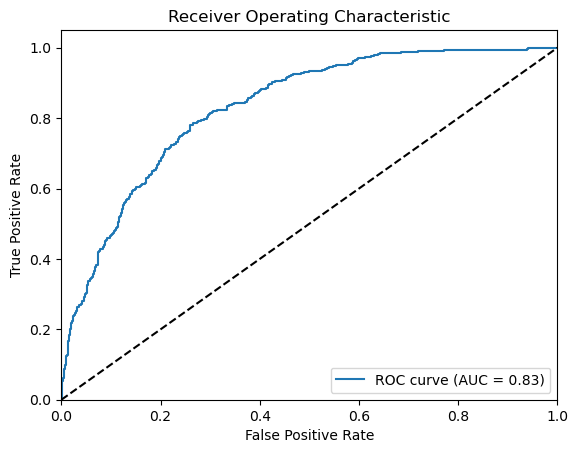

In [102]:
fpr, tpr, thresholds = roc_curve(y_test, z_test)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Plotting the random guessing curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [131]:
confusion_matrix = pd.crosstab(pd.Series(y_test, name='Actual'),
                               pd.Series((np.round(z_test.reshape(1, -1)) == 1)[0], name='Predicted'))

confusion_matrix

Predicted,False,True
Actual,,
False,3,1
True,342,90


In [137]:
precision = confusion_matrix.iloc[1, 1] / (confusion_matrix.iloc[1, 1] + confusion_matrix.iloc[0, 1])

In [138]:
recall = confusion_matrix.iloc[1, 0] / (confusion_matrix.iloc[1, 1] + confusion_matrix.iloc[0, 0])

In [139]:
# Display precision and accuracy

print("Precision:", precision)
print("Accuracy:", accuracy)

Precision: 0.989010989010989
Accuracy: 0.9908256880733946


In [152]:
column_names = enc.get_feature_names_out().tolist() + ['days', 'monthly_charges', 'total_charges']

In [156]:
feature_importance = model_ff.layers[0].get_weights()[0]

In [163]:
[x.mean() for x in feature_importance]

[0.010392983,
 0.034175247,
 -0.0022335462,
 -0.021322753,
 0.0008001439,
 -0.009857387,
 -0.013163676,
 -0.024082758,
 -0.019312376,
 -0.029641721,
 0.004450753,
 -0.011950035,
 -0.034843985,
 -0.008095067,
 -0.008948614,
 -0.023995822,
 0.004396116,
 -0.0036663665,
 -0.010592404,
 -0.0030323823]

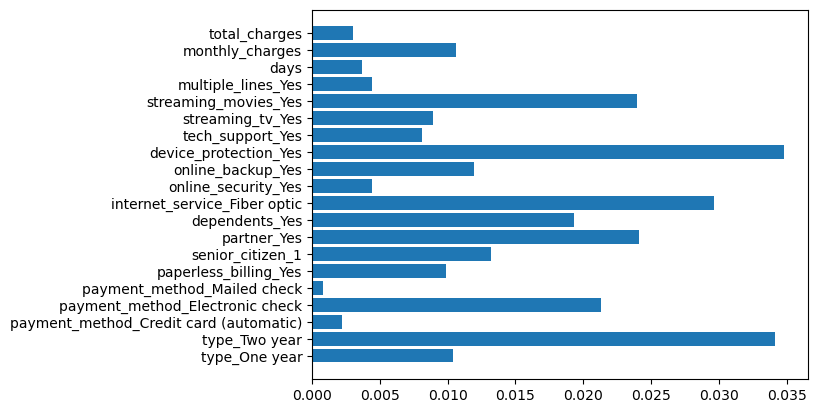

In [165]:
plt.barh(column_names, [abs(x.mean()) for x in feature_importance])
plt.show()

# Вывод

На данном этапе нужной метрики не получилось добится. Из матрицы ошибок создется впечатление что модель работает очень хорошо. Точно такое же впечатление создается из показателей полноты и точности. У меня не получилось применить 'predict_proba'. Из исследования важности показателей мы наблюдаем важность 'type_Two year' и 'device_protection_Yes'. Данное исследование не полное, так как совет был исползовать 'drop="first"' вместо 'drop="if_binary"'.